In [4]:
# Import
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise,GlobalAveragePooling2D,BatchNormalization,Dropout,Dense
from tensorflow.keras.models import Sequential


In [5]:
## Batch size and image size and Path specify
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_path = 'D:/archive/train'
test_path = 'D:/archive/test'
val_path = 'D:/archive/val'

# Data Processing

In [6]:
## Particular files kitne no. of images are and how many classes there
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(val_path,
                                                          shuffle=True,
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 3200 files belonging to 4 classes.
Found 2000 files belonging to 4 classes.
Found 800 files belonging to 4 classes.


In [7]:
class_names = train_dataset.class_names

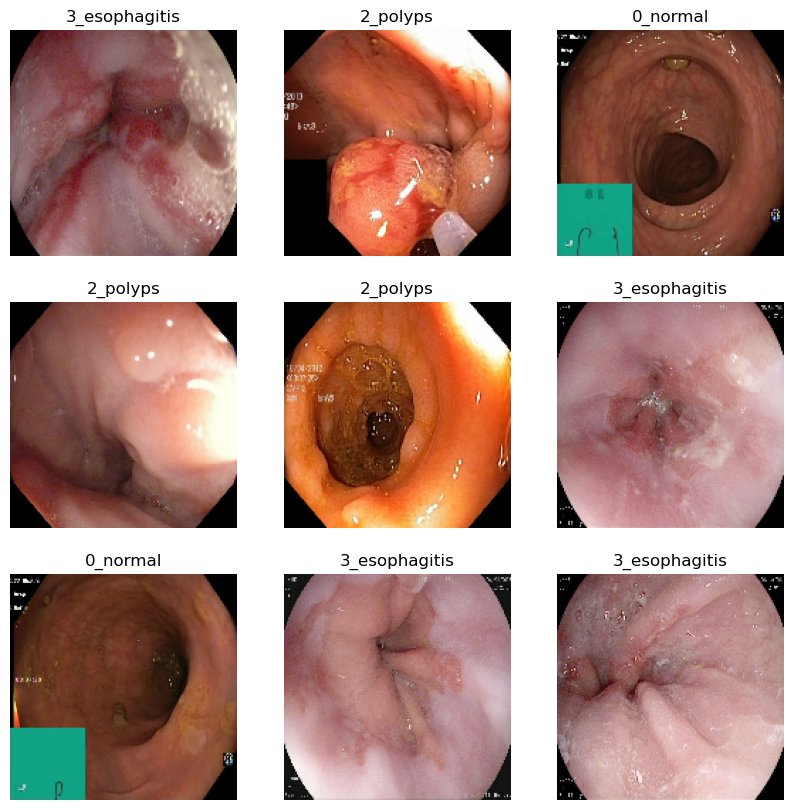

In [8]:
# Show the first nine images and labels from the training set

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 63
Number of test batches: 25


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

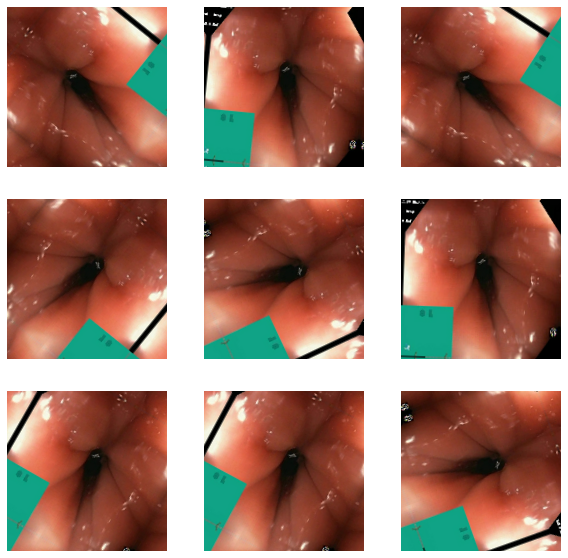

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [14]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Build Model

In [16]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [18]:
base_model.trainable = False

In [19]:
base_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 40, 40, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 40, 40, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 40, 40, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 40, 40, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 20, 20, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 20, 20, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 20, 20, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 20, 20, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [40]:
model = Sequential()
model.add(base_model) # Pre trained model feature extraction
model.add(data_augmentation) 
model.add(GaussianNoise(0.35)) # This is useful to mitigate overfitting 
model.add(GlobalAveragePooling2D()) # to generate predictions from the block of features, average over the spatial
model.add(Dense(256,activation='relu')) # is a layer that is deeply connected with its preceding layer
# A batch normalization layer looks at each batch as it comes in, first normalizing 
# the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters.
model.add(BatchNormalization())
model.add(GaussianNoise(0.35))
# To break up these conspiracies, 
# we randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data
dd(Dense(4, activation='softmax')) # get the 4 output based on classes using softmax as activation function
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 sequential (Sequential)     (None, None, None, None)  0         
                                                                 
 gaussian_noise_6 (GaussianN  (None, 5, 5, 2048)       0         
 oise)                                                           
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_3 (Batc  (None, 256)             

In [41]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=150
)

Epoch 1/150
100/100 [==============================] - 329s 3s/step - loss: 0.1664 - accuracy: 0.9425 - val_loss: 0.9823 - val_accuracy: 0.7815
Epoch 2/150
100/100 [==============================] - 223s 2s/step - loss: 0.0432 - accuracy: 0.9859 - val_loss: 0.8027 - val_accuracy: 0.7955
Epoch 3/150
100/100 [==============================] - 254s 3s/step - loss: 0.0364 - accuracy: 0.9866 - val_loss: 0.5773 - val_accuracy: 0.8385
Epoch 4/150
100/100 [==============================] - 257s 3s/step - loss: 0.0214 - accuracy: 0.9922 - val_loss: 0.8622 - val_accuracy: 0.7860
Epoch 5/150
100/100 [==============================] - 257s 3s/step - loss: 0.0186 - accuracy: 0.9947 - val_loss: 0.5846 - val_accuracy: 0.8395
Epoch 6/150
100/100 [==============================] - 256s 3s/step - loss: 0.0099 - accuracy: 0.9972 - val_loss: 0.6639 - val_accuracy: 0.8335
Epoch 7/150
100/100 [==============================] - 256s 3s/step - loss: 0.0174 - accuracy: 0.9937 - val_loss: 0.5259 - val_accuracy:

100/100 [==============================] - 426s 4s/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.9408 - val_accuracy: 0.8390
Epoch 106/150
100/100 [==============================] - 411s 4s/step - loss: 0.0035 - accuracy: 0.9987 - val_loss: 0.5492 - val_accuracy: 0.8890
Epoch 107/150
100/100 [==============================] - 366s 4s/step - loss: 7.4485e-04 - accuracy: 1.0000 - val_loss: 0.8541 - val_accuracy: 0.8490
Epoch 108/150
100/100 [==============================] - 420s 4s/step - loss: 5.8395e-04 - accuracy: 1.0000 - val_loss: 0.8381 - val_accuracy: 0.8560
Epoch 109/150
100/100 [==============================] - 429s 4s/step - loss: 5.6680e-04 - accuracy: 1.0000 - val_loss: 1.0768 - val_accuracy: 0.8280
Epoch 110/150
100/100 [==============================] - 419s 4s/step - loss: 5.5723e-04 - accuracy: 1.0000 - val_loss: 1.0489 - val_accuracy: 0.8370
Epoch 111/150
100/100 [==============================] - 419s 4s/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.8951

### Accuracy vs Epochs

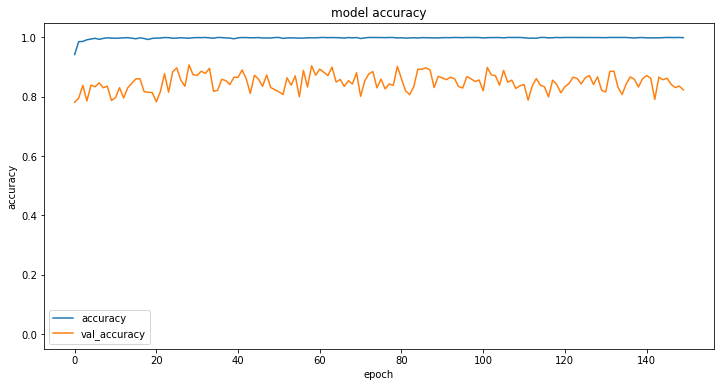

In [74]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.plot(range(0, 1))
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower left')
plt.show()

In [46]:
model.evaluate(train_dataset)


100/100 [==============================] - 240s 2s/step - loss: 1.6125e-05 - accuracy: 1.0000


[1.6124882677104324e-05, 1.0]

In [47]:
model.evaluate(val_dataset)


63/63 [==============================] - 162s 3s/step - loss: 1.4441 - accuracy: 0.8230


[1.4440879821777344, 0.8230000138282776]

In [57]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


25/25 [==============================] - 70s 3s/step - loss: 1.2858 - accuracy: 0.8363
Test accuracy : 0.8362500071525574


## Classification

In [106]:
from keras.preprocessing.image import ImageDataGenerator

In [107]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [113]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (160, 160),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                           shuffle=False)

Found 800 images belonging to 4 classes.


In [121]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [125]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis = 1)
Y_test = test_set.classes

25/25 [==============================] - 58s 2s/step


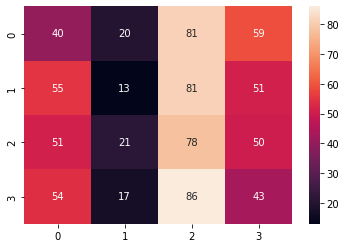

In [126]:
cm = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True,fmt="d")

# Save Model

In [9]:
from tensorflow.keras.models import load_model
import os



In [96]:

model.save(os.path.join('models','imageclassifier.h5'))


In [10]:
new_model = load_model('./models/imageclassifier.h5')

## Test

In [12]:
import cv2

img = cv2.imread(r"D:\archive\test\3_esophagitis\test_esophagitis_ (76).jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = tf.image.resize(RGB_img, (256,256))


In [13]:
ypred = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 248ms/step


THE UPLOADED IMAGE SEEMS TO BE: Esophagitis


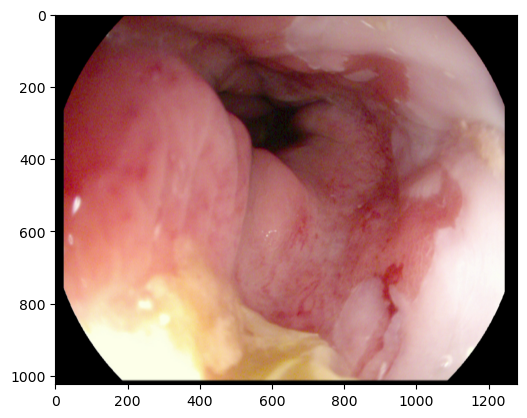

In [14]:
a=np.argmax(ypred,-1)
if a==0:
    op="Normal"
elif a==1:
    op="Ulcerative colitis"
elif a==2:
    op="Polyp"
else:
    op="Esophagitis"  

plt.imshow(RGB_img)
print("THE UPLOADED IMAGE SEEMS TO BE: "+str(op)) 